In [3]:
import re
from typing import List, Union, Tuple, Dict, Any, Optional

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
import selfies as sf

from utils import DataSet, grid_search, plot_results

# Set pandas to display all rows
pd.set_option("display.max_rows", None)

#### Example - generating LogExtCoeff estimator

##### Getting the data

In [12]:
target = 'LogExtCoeff'
lec_data = DataSet(target)
print(f'LEC y shape: {lec_data.y.shape}')
print(f'Features shape: {lec_data.X.shape}')
lec_data.X.info()

LEC y shape: (8037, 3)
Features shape: (8037, 209)
<class 'pandas.core.frame.DataFrame'>
Index: 8037 entries, 97 to 20215
Columns: 209 entries, MaxAbsEStateIndex to fr_urea
dtypes: float64(105), int64(104)
memory usage: 12.9 MB


In [3]:
#  Show any columns that have missing values
missing_values = lec_data.X.isnull().sum()
print(missing_values[missing_values > 0])

MaxPartialCharge       22
MinPartialCharge       22
MaxAbsPartialCharge    22
MinAbsPartialCharge    22
BCUT2D_MWHI            22
BCUT2D_MWLOW           22
BCUT2D_CHGHI           22
BCUT2D_CHGLO           22
BCUT2D_LOGPHI          22
BCUT2D_LOGPLOW         22
BCUT2D_MRHI            22
BCUT2D_MRLOW           22
dtype: int64


Only a small number of rows where `RDKit` was unable to calculate values for all descriptors.  Given low impact on training size - drop them. Droping from all for now to simplify - should really drop just from training set and then have to come up with a replacement strategy for missing values in the prediction function (mean or mode).

In [13]:
# Create a new dataset with the missing values dropped
lec_data = DataSet("LogExtCoeff", fill_na="drop")

Now let's look at the discrete vs continous features in the dataset.

In [5]:
# Split the features into discrete and continuous
discrete_features = lec_data.X.select_dtypes(include=['int64'])
continuous_features = lec_data.X.select_dtypes(include=['float64'])

Lets look at the scaling of the continous features to see if any anomalies.

In [6]:
continuous_features.describe().T

,count,mean,std,min,25%,50%,75%,max
MaxAbsEStateIndex,8015.0,1.081872e+01,4.366066e+00,0.000000,7.038621,1.199140e+01,1.363647e+01,2.088895e+01
MaxEStateIndex,8015.0,1.081872e+01,4.366066e+00,0.000000,7.038621,1.199140e+01,1.363647e+01,2.088895e+01
MinAbsEStateIndex,8015.0,3.623379e-01,3.492322e-01,0.000000,0.083865,2.267275e-01,5.769274e-01,4.000000e+00
MinEStateIndex,8015.0,-1.161581e+00,1.989052e+00,-8.681424,-3.239539,-4.025175e-01,2.004686e-01,4.000000e+00
qed,8015.0,3.859848e-01,2.352055e-01,0.015606,0.176110,3.571228e-01,5.820461e-01,9.413037e-01
MolWt,8015.0,4.777303e+02,2.536456e+02,16.043000,321.095000,4.124930e+02,5.586380e+02,2.052522e+03
HeavyAtomMolWt,8015.0,4.513360e+02,2.353218e+02,12.011000,304.267000,3.931220e+02,5.283980e+02,1.881865e+03
ExactMolWt,8015.0,4.773291e+02,2.534343e+02,16.031300,321.045964,4.121554e+02,5.582267e+02,2.050871e+03
MaxPartialCharge,8015.0,3.215669e-01,2.296585e-01,-0.123544,0.145886,2.653095e-01,3.625505e-01,1.044153e+00
MinPartialCharge,8015.0,-4.060037e-01,1.260774e-01,-0.872433,-0.493601,-3.987106e-01,-3.384536e-01,0.000000e+00


The `Ipc` descriptor is calculating some near infinite numbers - likely bugged.  Let's exclude it.

In [14]:
lec_data.drop_features(["Ipc"])

Now looking at the discrete features

In [8]:
discrete_features.describe().T

,count,mean,std,min,25%,50%,75%,max
NumValenceElectrons,8015.0,174.600499,96.578878,8.0,116.0,150.0,206.0,840.0
NumRadicalElectrons,8015.0,0.001123,0.033493,0.0,0.0,0.0,0.0,1.0
HeavyAtomCount,8015.0,34.883843,18.873863,1.0,23.0,30.0,41.0,150.0
NHOHCount,8015.0,0.472863,0.886626,0.0,0.0,0.0,1.0,10.0
NOCount,8015.0,4.344105,2.628835,0.0,3.0,4.0,6.0,18.0
NumAliphaticCarbocycles,8015.0,0.227199,0.645121,0.0,0.0,0.0,0.0,8.0
NumAliphaticHeterocycles,8015.0,0.756082,1.025391,0.0,0.0,0.0,1.0,22.0
NumAliphaticRings,8015.0,0.983281,1.200395,0.0,0.0,1.0,2.0,22.0
NumAromaticCarbocycles,8015.0,3.075109,2.446349,0.0,2.0,2.0,4.0,37.0
NumAromaticHeterocycles,8015.0,1.139114,1.066300,0.0,0.0,1.0,2.0,8.0


There are alot of the discrete descriptors.  Given the range of some of them (e.g. `NumValenceElectrons`) one-hot encoding them would explode the size of the input features.

Options:
1. Use only predictor models that cope well with mixed continous/discrete features e.g. Decision Trees.
2. Limit the data set to only those discrete values that are well represented in the dataset and have good range.
3. View all of the discrete values as being in some shape or form an encoding of the structure of the the molecule and replace all with an embedding of the `selfie` tokenized representation of the molecule.

##### Option 1: Random Forest

In [9]:
# Example of a grid search of a RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
params = {
    'n_estimators': [ 200 ],
    'max_depth': [ 20 ],
}

grid, y_pred, r2 = grid_search(rf, params, lec_data, scaler=None, model_name="LEC_RF", verbose=3)

Loading model: LEC_RF
Test R2 score: 0.824


In [17]:
mse = mean_squared_error(lec_data.y_test["LogExtCoeff"], y_pred)
print(f"Mean squared error: {mse:.2f}")

Mean squared error: 0.06


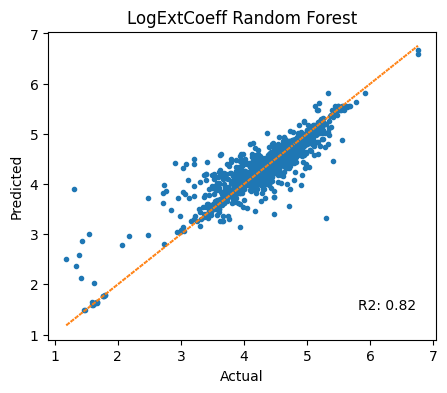

In [10]:

#Plot the results
plot_results(lec_data.y_test['LogExtCoeff'], y_pred, 'LogExtCoeff Random Forest', r2)

##### Option 2: limit discrete features

In [11]:
# Discrete Feature with few values > 0
discrete_gr_0 = discrete_features[discrete_features > 0].count()

#  Sort the discrete features by the number of values > 0
discrete_gr_0.sort_values(ascending=False, inplace=True)
display(discrete_gr_0)

NumValenceElectrons         8015
HeavyAtomCount              8015
RingCount                   7980
NumAromaticRings            7970
NumHeteroatoms              7841
NumHAcceptors               7669
NOCount                     7656
NumAromaticCarbocycles      7425
fr_benzene                  7425
NumRotatableBonds           7354
fr_NH0                      6695
fr_bicyclic                 5967
NumAromaticHeterocycles     5470
fr_Ar_N                     4652
NumAliphaticRings           4361
NumAliphaticHeterocycles    3611
fr_aniline                  3124
fr_allylic_oxid             2424
fr_para_hydroxylation       2392
NumHDonors                  2353
NHOHCount                   2352
fr_C_O                      2350
fr_ether                    2349
fr_C_O_noCOO                2197
fr_halogen                  2164
fr_aryl_methyl              2007
fr_methoxy                  1399
fr_NH1                      1326
NumAliphaticCarbocycles     1267
fr_nitrile                  1249
fr_pyridin

A lot of these discrete values are very sparsely represented in the dataset and would be difficult to train on.  Remove all with less than 1000 samples in the dataset.

In [12]:
features_less_that_500 = discrete_gr_0[discrete_gr_0 < 1000].index.to_list()
lec_data.drop_features(features_less_that_500)

In [13]:
discrete_features = lec_data.X.select_dtypes(include=['int64'])
discrete_features.describe().T


,count,mean,std,min,25%,50%,75%,max
NumValenceElectrons,8015.0,174.600499,96.578878,8.0,116.0,150.0,206.0,840.0
HeavyAtomCount,8015.0,34.883843,18.873863,1.0,23.0,30.0,41.0,150.0
NHOHCount,8015.0,0.472863,0.886626,0.0,0.0,0.0,1.0,10.0
NOCount,8015.0,4.344105,2.628835,0.0,3.0,4.0,6.0,18.0
NumAliphaticCarbocycles,8015.0,0.227199,0.645121,0.0,0.0,0.0,0.0,8.0
NumAliphaticHeterocycles,8015.0,0.756082,1.025391,0.0,0.0,0.0,1.0,22.0
NumAliphaticRings,8015.0,0.983281,1.200395,0.0,0.0,1.0,2.0,22.0
NumAromaticCarbocycles,8015.0,3.075109,2.446349,0.0,2.0,2.0,4.0,37.0
NumAromaticHeterocycles,8015.0,1.139114,1.066300,0.0,0.0,1.0,2.0,8.0
NumAromaticRings,8015.0,4.214223,2.526702,0.0,3.0,4.0,5.0,37.0


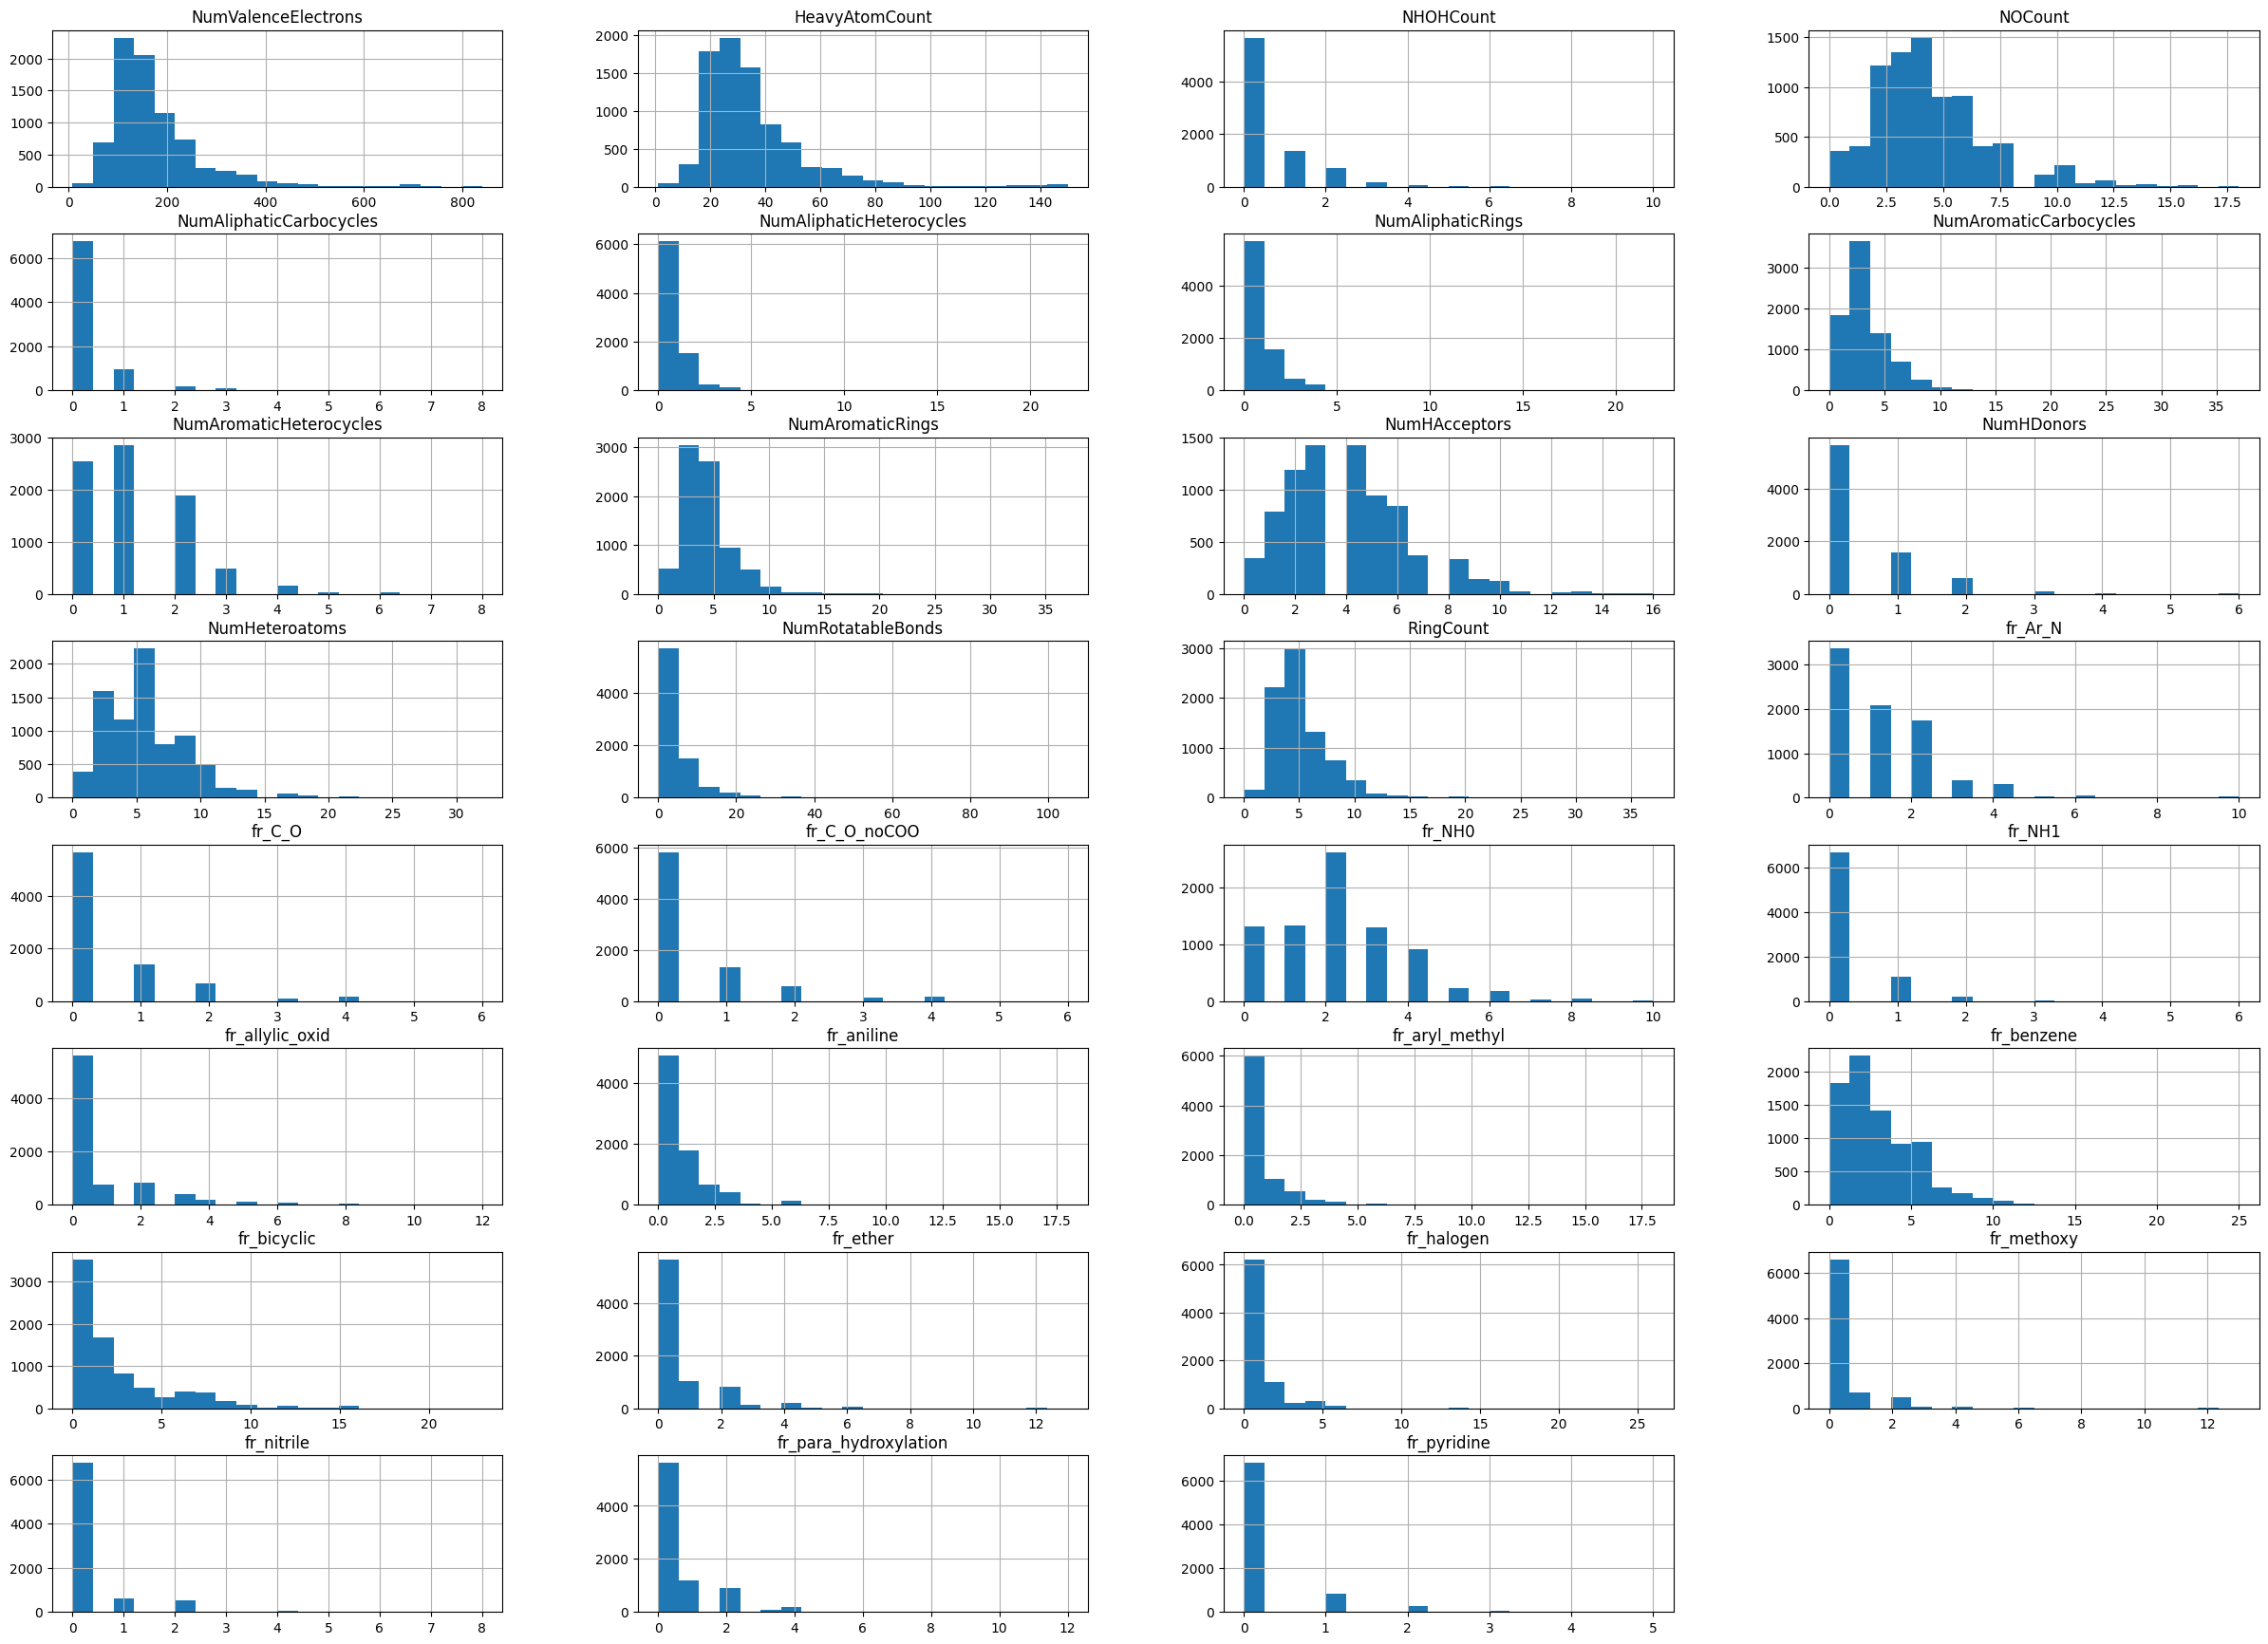

In [14]:

# show graph of the discrete features in a grid of 4 columns
_ = discrete_features.hist(figsize=(30, 30), bins=20, layout=(11, 4))

In [17]:
# Example of search for best Ridge Regression model using all features
estimator = Ridge(random_state=42)
scaler = StandardScaler()
params = {"alpha": [0.0, 0.05, 0.1]}

grid, y_pred, r2 = grid_search(
    estimator, params, lec_data, scaler=scaler, verbose=3
)

mse = mean_squared_error(lec_data.y_test["LogExtCoeff"], y_pred)
print(f"Mean squared error: {mse:.2f}")

Performing grid search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................est__alpha=0.05;, score=0.472 total time=   0.0s
[CV 2/5] END ...................est__alpha=0.05;, score=0.567 total time=   0.0s
[CV 4/5] END ....................est__alpha=0.0;, score=0.415 total time=   0.1s
[CV 4/5] END ...................est__alpha=0.05;, score=0.457 total time=   0.0s
[CV 2/5] END est__alpha=0.0;, score=-534623608071019338661888.000 total time=   0.1s
[CV 3/5] END ...................est__alpha=0.05;, score=0.477 total time=   0.0s
[CV 1/5] END ....................est__alpha=0.0;, score=0.466 total time=   0.1s
[CV 3/5] END est__alpha=0.0;, score=-33034052798374628701503488.000 total time=   0.1s
[CV 5/5] END ...................est__alpha=0.05;, score=0.506 total time=   0.0s
[CV 5/5] END ....................est__alpha=0.0;, score=0.278 total time=   0.1s
[CV 2/5] END ....................est__alpha=0.1;, score=0.567 total time=   0.0s
[CV 1/5] END 

In [19]:
# Continuous Features only
cols_to_drop = lec_data.X.select_dtypes(include=['int']).columns.to_list()
cols_to_drop.append('Ipc')
continous_lec_data = DataSet("LogExtCoeff", fill_na="drop", drop_features=cols_to_drop)

In [20]:
# Using only the continuous features
estimator_cont = Ridge(random_state=42)
scaler = StandardScaler()
params = {"alpha": [0.055, 0.06, 0.65]}

grid, y_pred, r2 = grid_search(
    estimator_cont, params, continous_lec_data, scaler=scaler, model_name=None, verbose=3
)

mse = mean_squared_error(lec_data.y_test["LogExtCoeff"], y_pred)
print(f"Mean squared error: {mse:.2f}")

Performing grid search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 5/5] END ..................est__alpha=0.055;, score=0.354 total time=   0.0s
[CV 2/5] END ...................est__alpha=0.06;, score=0.428 total time=   0.0s
[CV 1/5] END ..................est__alpha=0.055;, score=0.343 total time=   0.0s
[CV 2/5] END ..................est__alpha=0.055;, score=0.429 total time=   0.0s
[CV 4/5] END ..................est__alpha=0.055;, score=0.345 total time=   0.0s
[CV 3/5] END ..................est__alpha=0.055;, score=0.377 total time=   0.0s
[CV 4/5] END ...................est__alpha=0.06;, score=0.345 total time=   0.0s
[CV 5/5] END ...................est__alpha=0.06;, score=0.354 total time=   0.0s
[CV 1/5] END ...................est__alpha=0.65;, score=0.343 total time=   0.0s
[CV 3/5] END ...................est__alpha=0.06;, score=0.377 total time=   0.0s
[CV 2/5] END ...................est__alpha=0.65;, score=0.420 total time=   0.0s
[CV 4/5] END ..........